### Original violin plot figure probably has an issue:

> I did not realize at the time of submitting my manuscript that the bounding box coordinates change at each z-level

> Those plots were generated using the extent of bbox at 4km all throughout the $Z_{DR}$ column extent which </br>
can give slightly inaccurate values

> Here we attempt to rectify that mistake by accounting for bbox extent at each z-level separately

#### <span style="color:red">Turns out plotting flash initiations strictly within $Z_{DR}$ column bbox is not a good idea</span>.

> This is because most of the initiations occur way above the top of $Z_{DR}$ column 


In [1]:
import glob
import os
import warnings
from datetime import datetime

import cmocean.cm as cmo
import dask
import holoviews as hv
import hvplot.pandas
import hvplot.xarray
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import panel as pn
import seaborn
import xarray as xr
from matplotlib import patches
from skimage import io
from skimage.measure import label, regionprops, regionprops_table

# load custom colormaps
from may19_2013_obs_analysis import cmap_extent_density_b13, cmap_footprint_b13
from may19_2013_obs_analysis.zdr_flash_panel_plots import plot_flash_zdr
from may19_2013_obs_analysis.utils import npdt_to_datetime

seaborn.set(style="ticks")


plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["legend.markerscale"] = 2

In [2]:
# after manual verification of all the ZDR column objects at the 4km level, we list out the ones that are embedded within Edmond-Carney storm
# This should filter out artifacts (due to gridding or contamination from nearby storms)
# each list within the obj_interest list specifies the object labels that are of our interest.
# There are 42 such lists in obj_interest corresponding to all the times for which we have gridded radar data

# DO NOT change this!

zdr_obj_interest = [
    [3],
    [2],
    [2],
    [1, 2],
    [3],
    [1],
    [2, 3],
    [2, 3, 4, 5],
    [5, 6],
    [2],
    [4, 5],
    [3, 4],
    [2, 3],
    [2, 3],
    [5, 6],
    [3],
    [4, 5],
    [3, 4],
    [3, 4],
    [1, 2],
    [3, 4],
    [6, 7, 9],
    [1, 2, 3],
    [3, 4, 5],
    [2, 3],
    [2, 3, 4, 5],
    [1, 2, 3],
    [1, 2],
    [2, 3],
    [2, 3],
    [1, 4],
    [1, 2],
    [1, 2],
    [2, 3],
    [1, 2],
    [3, 4, 5],
    [1],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
]


# These are from new segmentation performed on kdp array on Nov 28, 2020
kdp_obj_interest = [
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [8],
    [4],
    [7],
    [3, 8],
    [3],
    [4],
    [3],
    [2],
    [4, 6],
    [2],
    [1],
    [2],
    [5],
    [5],
    [2, 3],
    [4],
    [4],
    [2],
    [1],
    [2],
    [3, 4],
    [2],
    [3, 4],
    [3],
    [3],
    [1],
    [1],
    [1],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
]

In [3]:
# Here we load the segmentation output files and get datetime objects for each time step from radar files

segmented_files_zdr = sorted(
    glob.glob("../data/processed/segmented_stacks/zdr/direct_array/*tiff")
)

segmented_files_kdp = sorted(
    glob.glob("../data/processed/segmented_stacks/kdp/direct_array/*tiff")
)

# rad_files = sorted(glob.glob('path/to/KTLX_data/*V06'))
rad_files = sorted(
    glob.glob("/Users/ms/Desktop/mount/May_19_2013_all_stuff/KTLX_data/*V06")
)
tmpstmps = [
    x.split("/")[-1][4:19] for x in rad_files
]  # access the time stamps from each radar file and convert those into datetime objects
dt_tmpstmps = [datetime.strptime(x, "%Y%m%d_%H%M%S") for x in tmpstmps]

In [4]:
# Here, we create a dataframe which stores the bbox region coordinates and label values for zdr column objects
# NOTE: These zdr column objects were identified from the segmentation result using direct array
# and not by reding files using the AICSImage reader.

final_zdr_df = pd.DataFrame()
for i in range(len(segmented_files_zdr)):

    cell_seg_reader = io.imread(segmented_files_zdr[i])
    cell_seg = cell_seg_reader
    seg = label(cell_seg)
    seg = np.fliplr(seg)

    # cell_seg = label(cell_seg[:,::-1,:])
    props = regionprops_table(seg, properties=["bbox", "bbox_area", "label"])

    df = pd.DataFrame(props)
    #     df.drop(labels=['time'],axis=1,inplace=True)

    df["time"] = dt_tmpstmps[i]
    df.index = df["time"]
    df.drop(labels=["time"], axis=1, inplace=True)

    df_sel = df[df["label"].isin(zdr_obj_interest[i])]
    # append zdr_col info df for current time step to the final_df
    final_zdr_df = final_zdr_df.append(df_sel,)

In [5]:
# Here, we create a dataframe which stores the bbox region coordinates and label values for kdp column objects
# NOTE: These kdp column objects were identified from the segmentation result using direct array
# and not by reding files using the AICSImage reader.

final_kdp_df = pd.DataFrame()
for i in range(len(segmented_files_kdp)):

    cell_seg_reader = io.imread(segmented_files_kdp[i])
    cell_seg = cell_seg_reader
    seg = label(cell_seg)
    seg = np.fliplr(seg)

    # cell_seg = label(cell_seg[:,::-1,:])
    props = regionprops_table(seg, properties=["bbox", "bbox_area", "label"])

    df = pd.DataFrame(props)
    #     df.drop(labels=['time'],axis=1,inplace=True)

    df["time"] = dt_tmpstmps[i]
    df.index = df["time"]
    df.drop(labels=["time"], axis=1, inplace=True)

    df_sel = df[df["label"].isin(kdp_obj_interest[i])]
    # append zdr_col info df for current time step to the final_df
    final_kdp_df = final_kdp_df.append(df_sel,)

In [6]:
# create a list of altitudes to be fed as pandas index
# the values here were known to us because of segmentation z-level limits
alts = np.arange(4000, 11500, 500)

mega_tt = pd.DataFrame()
for i in range(len(segmented_files_zdr)):
    cell_seg_reader = io.imread(segmented_files_zdr[i])
    cell_seg = cell_seg_reader
    seg = label(cell_seg)
    seg = np.fliplr(seg)

    tt = pd.DataFrame()
    for j in range(
        seg.shape[0]
    ):  # loop for moving through all z-levels (4000 to 11000 m)

        try:  # fails when there is no data to be measured in the segmented file

            # create a temporary dataframe to store region props at each z-level
            tmp = pd.DataFrame(
                regionprops_table(
                    seg[j, :, :], properties=["bbox", "bbox_area", "area", "label"]
                )
            )

            try:  # fails when no pixel with label of interest is left at a certain altitude level

                for k in range(
                    len(zdr_obj_interest[i])
                ):  # loop to account for all segmented objects (if multiple objects exist in a segmented file)

                    # filter out the row from tmp dataframe that corresponds to a particular object label
                    tmp1 = tmp[tmp["label"] == zdr_obj_interest[i][k]]

                    # create a multi-index dataframe to store info about time, obj label, and z-level of region props
                    # this will enable us to calculate ZDR/KDP intensity within accurately identified bbox regions at each z-level
                    tmp2 = pd.DataFrame(
                        tmp1.iloc[:, :6].values,
                        index=[[dt_tmpstmps[i]], [zdr_obj_interest[i][k]], [alts[j]]],
                        columns=tmp.columns[:6],
                    )
                    tt = tt.append(tmp2)
            except:
                pass
        except IndexError:
            pass

    # finally, append dataframe at each vertical level to obtain one dataframe per time (for all objects and z-levels)
    mega_tt = mega_tt.append(tt)

# rename indices of final dataframe for more clarity to user
mega_tt.index.names = ["time", "label", "altitude"]

# Next, we want to reorder the indices to have all region props for each object listed out sequentially
# before proceeding with the next object (if there exists any) in the same segmented file

# check out how max/min function works on nested lists at the following link
# https://stackoverflow.com/questions/34050113/how-does-the-min-max-function-on-a-nested-list-work
final_bbox_data_zdr = mega_tt.reindex(np.arange(max(max(zdr_obj_interest))), level=1)

In [17]:
# create a list of altitudes to be fed as pandas index
# the values here were known to us because of segmentation z-level limits
alts = np.arange(4000, 11500, 500)

mega_tt = pd.DataFrame()
for i in range(len(segmented_files_kdp)):
    cell_seg_reader = io.imread(segmented_files_kdp[i])
    cell_seg = cell_seg_reader
    seg = label(cell_seg)
    seg = np.fliplr(seg)

    tt = pd.DataFrame()
    for j in range(
        seg.shape[0]
    ):  # loop for moving through all z-levels (4000 to 11000 m)

        try:  # fails when there is no data to be measured in the segmented file

            # create a temporary dataframe to store region props at each z-level
            tmp = pd.DataFrame(
                regionprops_table(
                    seg[j, :, :], properties=["bbox", "bbox_area", "area", "label"]
                )
            )

            try:  # fails when no pixel with label of interest is left at a certain altitude level

                for k in range(
                    len(kdp_obj_interest[i])
                ):  # loop to account for all segmented objects (if multiple objects exist in a segmented file)

                    # filter out the row from tmp dataframe that corresponds to a particular object label
                    tmp1 = tmp[tmp["label"] == kdp_obj_interest[i][k]]

                    # create a multi-index dataframe to store info about time, obj label, and z-level of region props
                    # this will enable us to calculate ZDR/KDP intensity within accurately identified bbox regions at each z-level
                    tmp2 = pd.DataFrame(
                        tmp1.iloc[:, :6].values,
                        index=[[dt_tmpstmps[i]], [kdp_obj_interest[i][k]], [alts[j]]],
                        columns=tmp.columns[:6],
                    )
                    tt = tt.append(tmp2)
            except:
                pass
        except IndexError:
            pass

    # finally, append dataframe at each vertical level to obtain one dataframe per time (for all objects and z-levels)
    mega_tt = mega_tt.append(tt)

# rename indices of final dataframe for more clarity to user
mega_tt.index.names = ["time", "label", "altitude"]

# Next, we want to reorder the indices to have all region props for each object listed out sequentially
# before proceeding with the next object (if there exists any) in the same segmented file

# check out how max/min function works on nested lists at the following link
# https://stackoverflow.com/a/55846534/12538451
final_bbox_data_kdp = mega_tt.reindex(np.arange([max((y for y in x if y is not np.nan), default=None) for x in zip(*kdp_obj_interest)][0]), level=1)

In [ ]:
# function to calculate statistical properties of actual ZDR/KDP values within identified objects from segmented output


def flash_prop_count(grid_data, final_bbox_data, dt, field):
    """
    
    Input:
    --------
    grid_data (xarray dataset): gridded flash product
    final_bbox_data (pandas dataframe): full bounding box data for ZDR column objects
    dt (datetime object): datetime at which flash properties need to be calculated
    field (str) : field of choice from flash data 
            
    Returns:
    --------
    xarray dataset with flash initiation density or mean flash area within each object 
    of interest at all the z-levels
    """
    bbox_data = final_bbox_data.loc[dt]
    flash_data = grid_data.sel(start_time=str(dt)).isel(y0=slice(None,241))
    field_data = flash_data[field]

    if len(np.unique(bbox_data.index.get_level_values("label"))) == 1:

        zvals = bbox_data.index.get_level_values("altitude")
        final_field_data = []

        #         access data corresponding to multiindex levels in pandas dataframes using query
        #         idea source: https://stackoverflow.com/questions/53927460/select-rows-in-pandas-multiindex-dataframe
        for zval in zvals:
            left_x = (
                field_data.sel(z0=zval)["x0"]
                .isel(x0=bbox_data.query(f"altitude == {zval}")["bbox-1"] - 1)
                .data[0]
            )
            left_y = (
                field_data.sel(z0=zval)["y0"]
                .isel(y0=bbox_data.query(f"altitude == {zval}")["bbox-0"] - 1)
                .data[0]
            )

            width = (
                field_data.sel(z0=zval)["x0"]
                .isel(x0=bbox_data.query(f"altitude == {zval}")["bbox-3"] - 1)
                .data[0]
                - field_data["x0"]
                .isel(x0=bbox_data.query(f"altitude == {zval}")["bbox-1"] - 1)
                .data[0]
            )
            height = (
                field_data.sel(z0=zval)["y0"]
                .isel(y0=bbox_data.query(f"altitude == {zval}")["bbox-2"] - 1)
                .data[0]
                - field_data["y0"]
                .isel(y0=bbox_data.query(f"altitude == {zval}")["bbox-0"] - 1)
                .data[0]
            )

            field_data_alt = field_data.sel(
                x0=slice(left_x, left_x + width),
                y0=slice(left_y, left_y + height),
                z0=zval,
            )
            final_field_data.append(field_data_alt.sum(dim=['x0','y0']))

        return xr.concat(final_field_data, dim="z", join="outer")

    elif len(np.unique(bbox_data.index.get_level_values("label"))) > 1:
        labels = np.unique(bbox_data.index.get_level_values("label"))
        tmp_ds = xr.Dataset()

        for label in labels:
            sub_box_data = bbox_data.query(f"label == {label}")
            zvals = sub_box_data.index.get_level_values("altitude")

            final_field_data = []

            #         access data corresponding to multiindex levels in pandas dataframes using query
            #         idea source: https://stackoverflow.com/questions/53927460/select-rows-in-pandas-multiindex-dataframe
            for zval in zvals:
                left_x = (
                    field_data.sel(z0=zval)["x0"]
                    .isel(
                        x0=sub_box_data.query(f"altitude == {zval}")["bbox-1"] - 1
                    )  # bbox coordinates are defined on an open interval [low,high); so subtracting 1
                    .data[0]
                )
                left_y = (
                    field_data.sel(z0=zval)["y0"]
                    .isel(y0=sub_box_data.query(f"altitude == {zval}")["bbox-0"] - 1)
                    .data[0]
                )

                width = (
                    field_data.sel(z0=zval)["x0"]
                    .isel(x0=sub_box_data.query(f"altitude == {zval}")["bbox-3"] - 1)
                    .data[0]
                    - field_data["x0"]
                    .isel(x0=sub_box_data.query(f"altitude == {zval}")["bbox-1"] - 1)
                    .data[0]
                )

                height = (
                    field_data.sel(z0=zval)["y0"]
                    .isel(y0=sub_box_data.query(f"altitude == {zval}")["bbox-2"] - 1)
                    .data[0]
                    - field_data["y0"]
                    .isel(y0=sub_box_data.query(f"altitude == {zval}")["bbox-0"] - 1)
                    .data[0]
                )

                field_data_alt = field_data.sel(
                    x0=slice(left_x, left_x + width),
                    y0=slice(left_y, left_y + height),
                    z0=zval,
                )
                final_field_data.append(field_data_alt)
            
            xr_data = xr.concat(final_field_data, dim="z", join="outer").squeeze().sum(dim=['x0','y0'])
            tmp_ds[f"zdrcol_{label}"] = (
                (f"z_{label}"),
                xr_data,
            )
#             print(tmp_ds)
#             print(xr_data)
            
            tmp_ds.coords[f"z_{label}"] = (f"z_{label}", zvals)
#             tmp_ds.coords[f"x_{label}"] = (f"x_{label}", xr_data.x0.data)
#             tmp_ds.coords[f"y_{label}"] = (f"y_{label}", xr_data.y0.data)
            
            

        return tmp_ds
#         return xr_data

In [ ]:
flash_ini_files = sorted(glob.glob('/Users/ms/Desktop/mount/May_19_2013_all_stuff/May19_LMA_sorted/flashsort/' \
                         'grid_files20002300_per_radar_grid_500x500x500m_KTLX_per_PyART/2013/May/19/*_flash_init_3d.nc'))
flash_ini_data = xr.open_mfdataset(flash_ini_files,engine='h5netcdf',combine='nested',concat_dim=['t'],data_vars='different').squeeze()
flash_ini_data = flash_ini_data.set_coords(['latitude','longitude','altitude','time'])
flash_ini_data = flash_ini_data['flash_initiation'].squeeze().rename({'t':'start_time','lon':'x0','lat':'y0','alt':'z0'})


flash_foot_files = sorted(glob.glob('/Users/ms/Desktop/mount/May_19_2013_all_stuff/May19_LMA_sorted/flashsort/' \
                         'grid_files20002300_per_radar_grid_500x500x500m_KTLX_per_PyART/2013/May/19/*_footprint_3d.nc'))
flash_foot_data = xr.open_mfdataset(flash_foot_files,engine='h5netcdf',combine='nested',concat_dim=['t'],data_vars='different').squeeze()
flash_foot_data = flash_foot_data.set_coords(['latitude','longitude','altitude','time'])
flash_foot_data = flash_foot_data['flash_footprint'].squeeze().rename({'t':'start_time','lon':'x0','lat':'y0','alt':'z0'})

# flash_ini_data.assign_coords({'tim':flash_ini_data.time.squeeze().data})

In [ ]:
gridded_flash_data = xr.Dataset({'flash_ini':flash_ini_data,'flash_footprint':flash_foot_data})
gridded_flash_data = gridded_flash_data.assign_coords({'start_time':gridded_flash_data.time.data})
gridded_flash_data = gridded_flash_data.assign_coords({'z0':gridded_flash_data['flash_ini'].altitude.data})
gridded_flash_data = gridded_flash_data.assign_coords({'x0':gridded_flash_data['flash_ini'].longitude.data})
gridded_flash_data = gridded_flash_data.assign_coords({'y0':gridded_flash_data['flash_ini'].latitude.data})

In [ ]:
zdr_flash_ini_alt = []
for i in range(len(dt_tmpstmps)):
    zdr_col_flash_ini_data = flash_prop_count(
        gridded_flash_data, final_bbox_data, str(dt_tmpstmps[i]), "flash_ini"
    )
    
    try:
#         zdr_col_flash_ini_data = zdr_col_flash_ini_data.where(zdr_col_flash_ini_data > 1)

        if isinstance(zdr_col_flash_ini_data, xr.DataArray):
            zdr_col_flash_ini_data = zdr_col_flash_ini_data.expand_dims({'time':1})
            zdr_col_flash_ini_data = zdr_col_flash_ini_data.rename({'z':'z0'})
            zdr_col_flash_ini_data = zdr_col_flash_ini_data.drop(['altitude','start_time'])
            #         print(zdr_col_data)
            zdr_flash_ini_alt.append(zdr_col_flash_ini_data)
        elif isinstance(zdr_col_flash_ini_data, xr.Dataset):
            var_names = list(zdr_col_flash_ini_data.data_vars.variables)
            for j in range(len(var_names)):
                var = var_names[j]
                var_data = zdr_col_flash_ini_data[var]
                dims = var_data.dims
                tmp = var_data.rename(dict(zip(dims, ("z"))))
#                 tmp = tmp.mean(dim=["x", "y"])
                tmp = tmp.assign_coords({"time": dt_tmpstmps[i]})
                tmp = tmp.expand_dims("time")
                tmp = tmp.rename({'z':'z0'})
                #             print(tmp)
                zdr_flash_ini_alt.append(tmp)

    except AttributeError:
        # fails when there is no zdr column data 
        pass


In [ ]:
# concatenate list of dataarrays into a single dataarray
full_zdr_flash_ini_alt_da = xr.concat(zdr_flash_ini_alt, dim="time")

# convert dataarray to dataframe to plot data using seaborn
full_zdr_flash_ini_alt = full_zdr_flash_ini_alt_da.to_dataframe()
full_zdr_flash_ini_alt = full_zdr_flash_ini_alt.reset_index(level=["time", "z"])
# full_zdr_prop_alt

# add hue column in the dataframe
full_zdr_flash_ini_alt["hue"] = full_zdr_flash_ini_alt["z"].astype("category")
full_zdr_flash_ini_alt

#### Let's do a sanity check and find out if bbox around image segmented vs direct array do a decent job of capturing $Z_{DR}$ column region

In [19]:
ktlx_grid_data = xr.open_mfdataset('/Users/ms/Desktop/mount/May_19_2013_all_stuff/KTLX_data/gridded_ktlx/*.nc')

In [20]:
zdr_data = ktlx_grid_data['differential_reflectivity']

/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


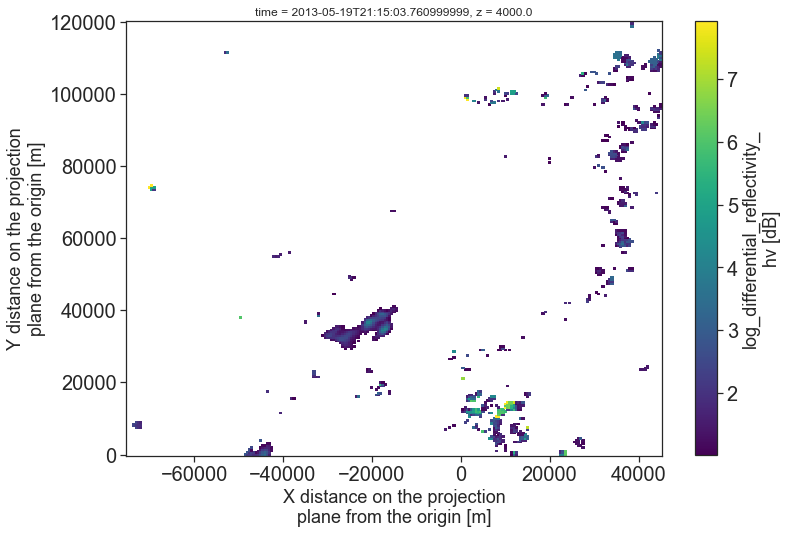

In [21]:
zdr_data.where(zdr_data>1).isel(time=17).sel(z=4000).plot()

In [22]:
# function to calculate statistical properties of actual ZDR/KDP values within identified objects from segmented output

from matplotlib import patches

def plot_bbox_zdr_col(grid_data,final_bbox_data, dt, field):
    """
    
    Input:
    --------
    grid_data (xarray dataset): gridded flash product
    final_bbox_data (pandas dataframe): full bounding box data for ZDR column objects
    dt (datetime object): datetime at which flash properties need to be calculated
    field (str) : field of choice from flash data 
            
    Returns:
    --------
    xarray dataset with flash initiation density or mean flash area within each object 
    of interest at all the z-levels
    """
    bbox_data = final_bbox_data.loc[dt]
    radar_data = grid_data.sel(time=str(dt))
    field_data = radar_data[field].where(radar_data[field] > 1)

    if len(np.unique(bbox_data.index.get_level_values("label"))) == 1:

        zvals = bbox_data.index.get_level_values("altitude")
        final_field_data = []

        #         access data corresponding to multiindex levels in pandas dataframes using query
        #         idea source: https://stackoverflow.com/questions/53927460/select-rows-in-pandas-multiindex-dataframe
        for zval in zvals:
            left_x = (
                field_data.sel(z=zval)["x"]
                .isel(x=bbox_data.query(f"altitude == {zval}")["bbox-1"] - 1)
                .data[0]
            )
            left_y = (
                field_data.sel(z=zval)["y"]
                .isel(y=bbox_data.query(f"altitude == {zval}")["bbox-0"] - 1)
                .data[0]
            )

            width = (
                field_data.sel(z=zval)["x"]
                .isel(x=bbox_data.query(f"altitude == {zval}")["bbox-3"] - 1)
                .data[0]
                - field_data["x"]
                .isel(x=bbox_data.query(f"altitude == {zval}")["bbox-1"] - 1)
                .data[0]
            )
            height = (
                field_data.sel(z=zval)["y"]
                .isel(y=bbox_data.query(f"altitude == {zval}")["bbox-2"] - 1)
                .data[0]
                - field_data["y"]
                .isel(y=bbox_data.query(f"altitude == {zval}")["bbox-0"] - 1)
                .data[0]
            )
            
            rect = patches.Rectangle(
                    (left_x, left_y),
                    width,
                    height,
                    linewidth=1,
                    edgecolor="r",
                    facecolor="none",
                )
            
            fig,ax = plt.subplots()
            
            p = field_data.sel(z=zval).plot(ax=ax)
            ax.add_patch(rect)
            plt.show()
            
#         return fig

#             field_data_alt = field_data.sel(
#                 x0=slice(left_x, left_x + width),
#                 y0=slice(left_y, left_y + height),
#                 z0=zval,
#             )
#             final_field_data.append(field_data_alt.sum(dim=['x','y']))
        
#         return left_x,left_y,width,height

    elif len(np.unique(bbox_data.index.get_level_values("label"))) > 1:
        labels = bbox_data.index.get_level_values(level='label').drop_duplicates()
        zvals = bbox_data.index.get_level_values(level='altitude').drop_duplicates()
        tt = {}
        for zval in zvals:
            left_xs = {}
            left_ys = {}
            widths = {} 
            heights = {}
            tt[zval] = {}
            for i in range(len(labels)):
                tt[zval][labels[i]] ={}
                sub_box_data = bbox_data.xs(labels[i],level='label')
                
                try:
                    
                    left_x = (
                                field_data.sel(z=zval)["x"]
                                .isel(
                                    x=sub_box_data.query(f"altitude == {zval}")["bbox-1"] - 1
                                )  # bbox coordinates are defined on an open interval [low,high); so subtracting 1
                                .data[0]
                            )

                    tt[zval][labels[i]]['left_x'] = left_x
                
                except:
                    left_x = np.nan
                
                try:
                    
                    left_y = (
                        field_data.sel(z=zval)["y"]
                        .isel(y=sub_box_data.query(f"altitude == {zval}")["bbox-0"] - 1)
                        .data[0]
                    )

                    tt[zval][labels[i]]['left_y'] = left_y
                
                except:
                    left_y = np.nan
                    
                try:
                    
                
                    width = (
                        field_data.sel(z=zval)["x"]
                        .isel(x=sub_box_data.query(f"altitude == {zval}")["bbox-3"] - 1)
                        .data[0]
                        - field_data["x"]
                        .isel(x=sub_box_data.query(f"altitude == {zval}")["bbox-1"] - 1)
                        .data[0]
                    )

                    tt[zval][labels[i]]['width'] = width
                
                except:
                    width = np.nan
                    
                try:
                    

                    height = (
                        field_data.sel(z=zval)["y"]
                        .isel(y=sub_box_data.query(f"altitude == {zval}")["bbox-2"] - 1)
                        .data[0]
                        - field_data["y"]
                        .isel(y=sub_box_data.query(f"altitude == {zval}")["bbox-0"] - 1)
                        .data[0]
                    )

                    tt[zval][labels[i]]['height'] = height
                
                except:
                    height = np.nan
        
        dict_of_df = {k: pd.DataFrame(v) for k,v in tt.items()}
        df = pd.concat(dict_of_df, axis=1)
        
#         print(df)
        for zval in zvals:
            
            fig,ax = plt.subplots()
            p = field_data.sel(z=zval).plot(ax=ax)
            
            for label in labels:
                left_x = df[zval][label]['left_x']
                left_y = df[zval][label]['left_y']
                width = df[zval][label]['width']
                height = df[zval][label]['height']
                
                rect = patches.Rectangle((left_x, left_y),
                                        width,
                                        height,
                                        linewidth=1,
                                        edgecolor="r",
                                        facecolor="none",
                                    )
                ax.add_patch(rect)
                
            plt.show()
            
            

#         return bbox_coords_data
#         return xr_data

In [ ]:
plot_bbox_zdr_col(ktlx_grid_data, final_bbox_data_zdr, dt_tmpstmps[17], 'differential_reflectivity')

/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


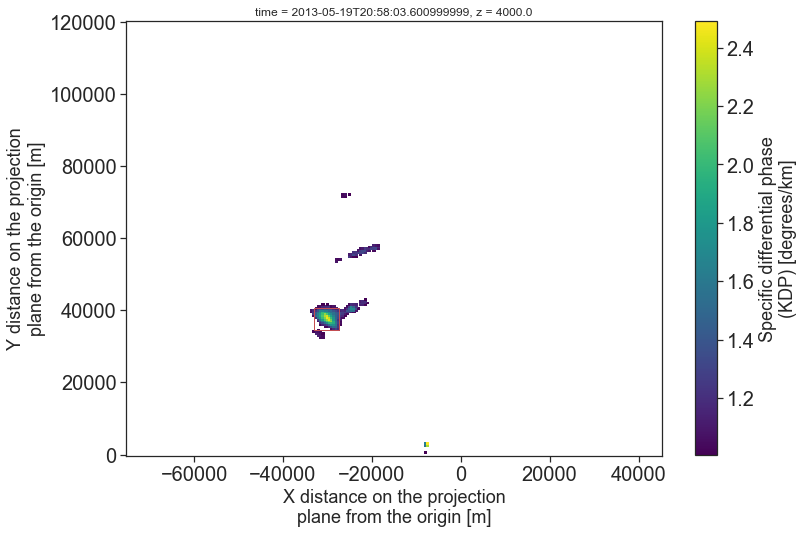

/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


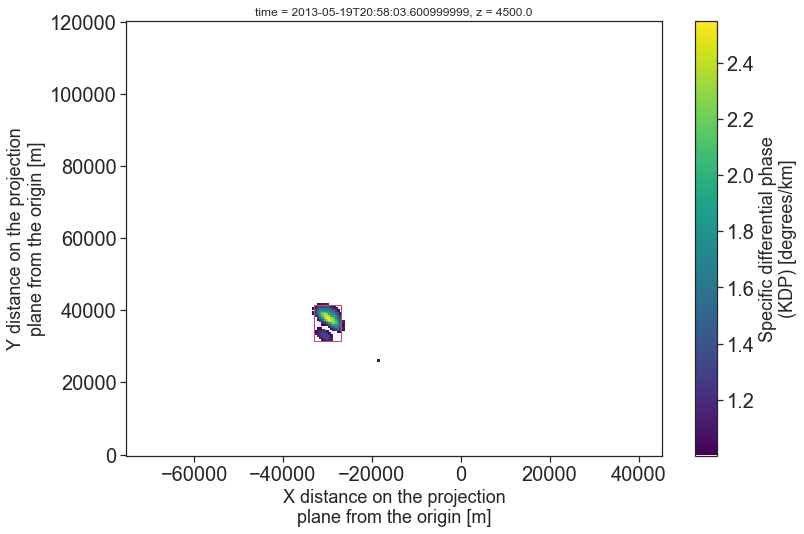

/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


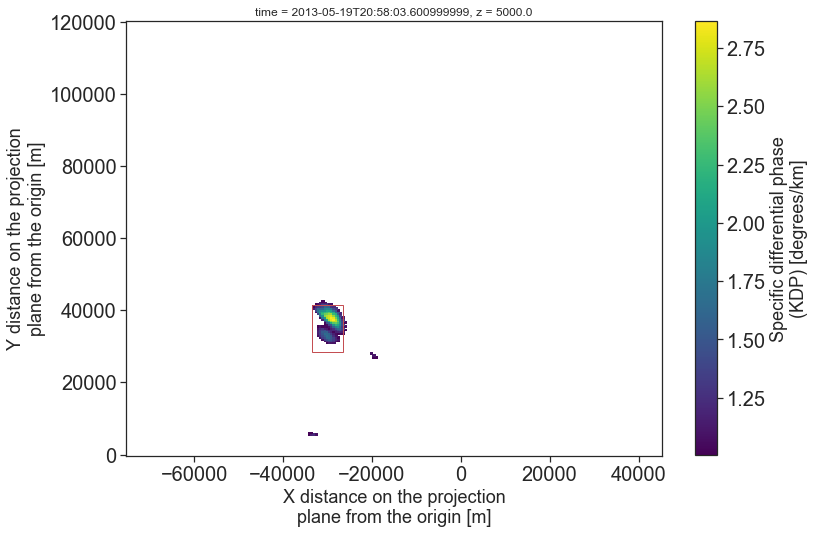

/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


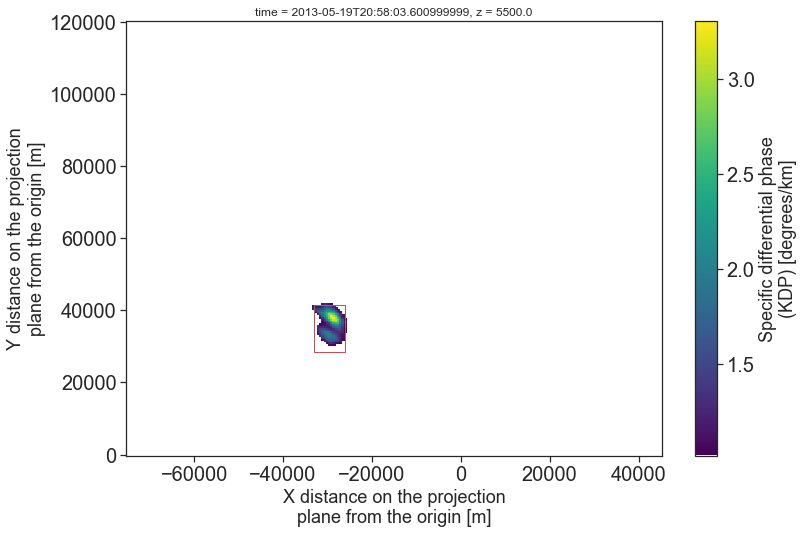

/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


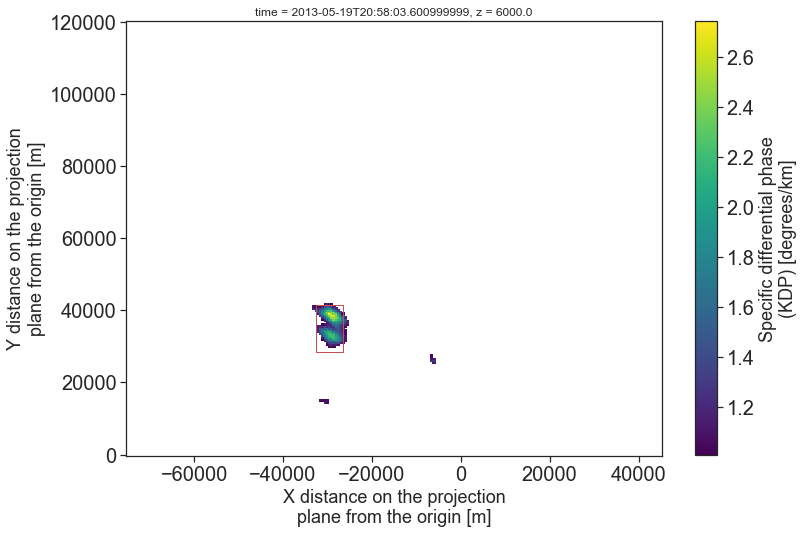

/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


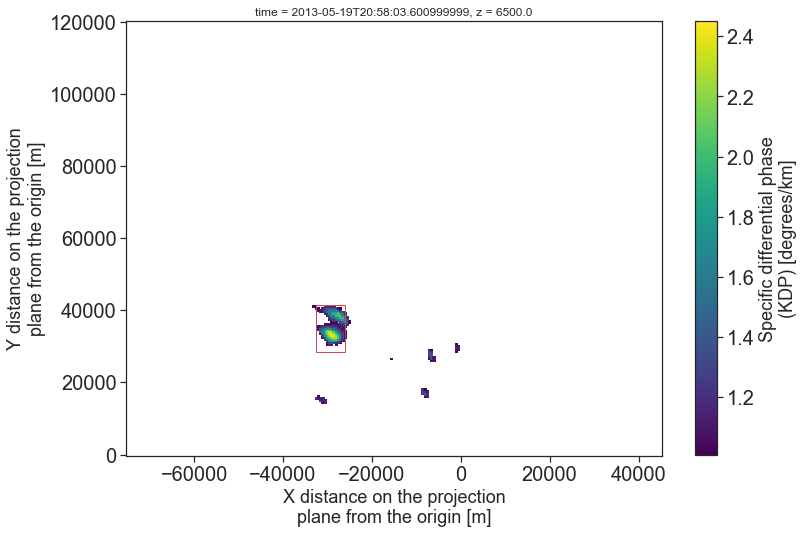

/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


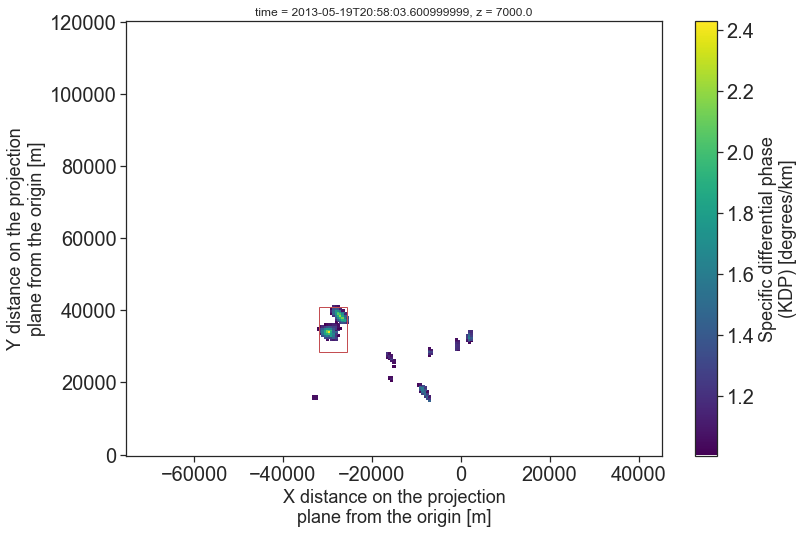

/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


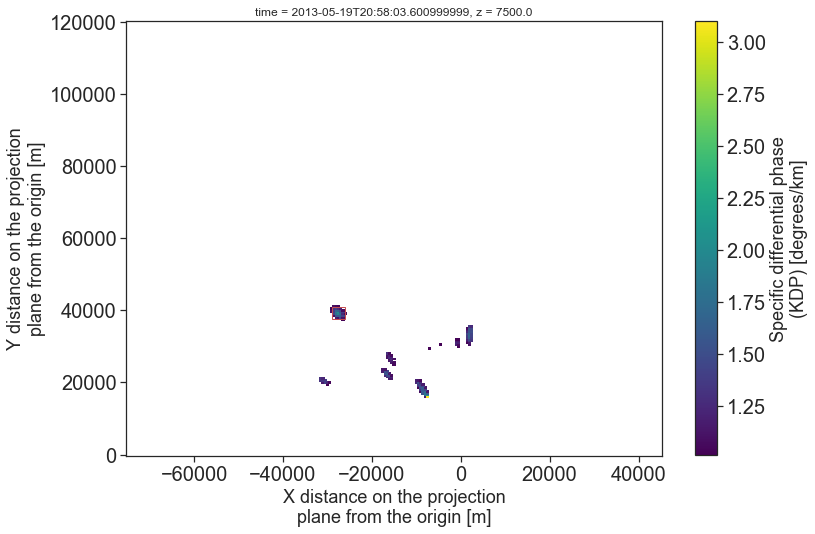

/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


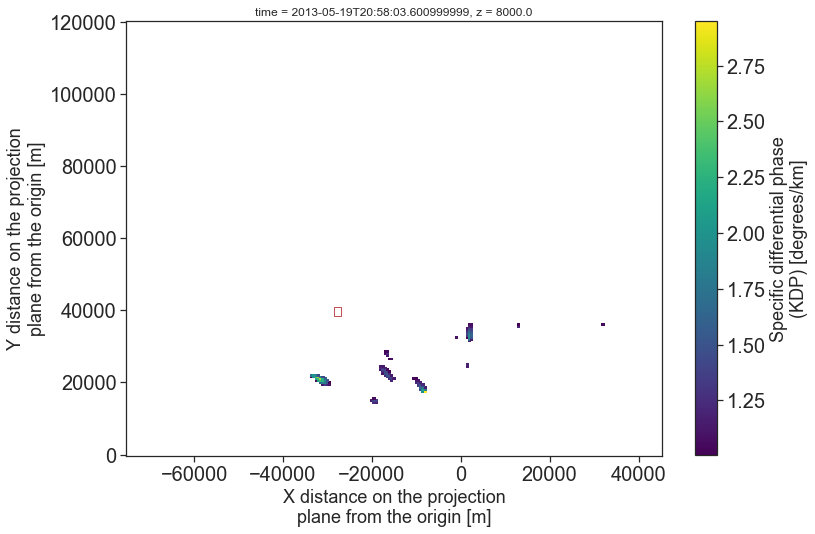

In [25]:
# will work with i >= 8 in dt_tmpstmps[i] because no kdp objs present before that

plot_bbox_zdr_col(ktlx_grid_data, final_bbox_data_kdp, dt_tmpstmps[13], 'kdp')

### Attempt to record labels of objects of interest for KDP columns from direct array segmentation output

In [ ]:
import napari
%gui qt

In [ ]:
# This will create a napari viewer for the entire 4D (t,x,y,z) stack created for segmented images

import matplotlib.cm as cm
import napari
import pyart
from dask_image.imread import imread
from skimage import measure
from vispy.color import Colormap

# stack = imread("/Users/sharm261/Desktop/mount/May_19_2013_all_stuff/stack_images_kdp/segmented_stacks/*.tiff")
stack = imread("/Users/ms/Desktop/kdp_direct_segmentation_new/*.tiff")

# sicne napari has limited colormaps and we want to use our custom colormap
cmap = cm.get_cmap("pyart_HomeyerRainbow", 15)
rgb_list = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    rgb_list.append(rgb)
rgb_list[0] = (0, 0, 0)

cmap = Colormap(rgb_list)

# define a function which reads only the last three dimensions since our stacked object is 4D
# concept credit: https://napari.org/tutorials/dask


def last3dims(f):
    # this is just a wrapper because the pycudadecon function
    # expects ndims==3 but our blocks will have ndim==4
    def func(array):
        return f(array[0])[None, ...]

    return func


label = last3dims(measure.label)

labeled = stack.map_blocks(label)

with napari.gui_qt():
    napari.view_image(
        labeled, contrast_limits=[0, 15], colormap=("HomeyerRainbow", cmap)
    )

In [ ]:
grid_data = xr.open_mfdataset('/Users/ms/Desktop/mount/May_19_2013_all_stuff/KTLX_data/gridded_ktlx/*.nc')

In [ ]:
tidx = 22
zidx = 8
zdralpha = 0.1
kdpalpha = 0.9
grid_data['kdp'].where(grid_data['kdp'] > 0.75).isel(time=tidx,z=zidx).plot(alpha=kdpalpha)
grid_data['differential_reflectivity'].where(grid_data['differential_reflectivity'] > 1).isel(time=tidx,z=zidx).plot(vmin=1,vmax=7,cmap='inferno',alpha=zdralpha)
